# Moving Average
This strategy does not look at the current price but instead at the moving average of the price pa. We will consider different time intervals for calculating the moving average: two hours, six hours, one day, seven days, 30 days, 100 days, and 200 days. The liquidity position of this strategy will be [pa − a, pa + a]. As in the constant interval strategy 4.3, the leftover token will not be used to provide any liquidity.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta

from demeter import (
    TokenInfo,
    Actuator,
    Strategy,
    simple_moving_average,
    ChainType,
    MarketInfo,
    PeriodTrigger,
    BaseAction
)
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter import Snapshot


In [3]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from decimal import Decimal
from demeter import TokenInfo, Actuator, Strategy, ChainType, MarketInfo, PeriodTrigger
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter import Snapshot


# Token and Market setup
usdc = TokenInfo(name="usdc", decimal=6)
eth = TokenInfo(name="eth", decimal=18)
pool_address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
market_key = MarketInfo("market1")
start_date = date(2025, 1, 1)
end_date = date(2025, 3, 1)

# Load market data function
def load_market_data(market, data_path="../data"):
    market.data_path = data_path
    market.load_data(
        chain=ChainType.ethereum.name,
        contract_addr=pool_address,
        start_date=start_date,
        end_date=end_date,
    )
    return market

# Define Moving Average Strategy with dynamic thresholds and ranges
class MovingAverageStrategy(Strategy):
    def __init__(self, threshold=25, liquidity_range=100, update_interval=timedelta(days=1)):
        super().__init__()
        self.threshold = threshold
        self.liquidity_range = liquidity_range
        self.update_interval = update_interval

    def initialize(self):
        self.add_column(market_key, "sma", simple_moving_average(self.data[market_key].price, window=timedelta(days=1)))
        self.triggers.append(PeriodTrigger(time_delta=self.update_interval, trigger_immediately=True, do=self.rebalance))

    def rebalance(self, row_data: Snapshot):
        self.markets[market_key].even_rebalance(row_data.market_status[market_key].price)

    def work(self, row_data: Snapshot):
        lp_market: UniLpMarket = self.markets[market_key]
        current_price = row_data.market_status[market_key].price
        ma_price = self.data[market_key].loc[row_data.timestamp]["sma"]
        ma_price = row_data.market_status[market_key].price if math.isnan(ma_price) else ma_price

        # Strategy based on moving average threshold and liquidity range
        if current_price > ma_price + self.threshold and len(lp_market.positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price, current_price + self.liquidity_range)
        elif current_price < ma_price - self.threshold and len(lp_market.positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price - self.liquidity_range, current_price)

# Function to run strategy and capture performance metrics
def run_strategy(threshold, liquidity_range, update_interval):
    market = load_market_data(UniLpMarket(market_key, UniV3Pool(usdc, eth, 0.05, usdc)))
    actuator = Actuator()
    actuator.broker.add_market(market)
    actuator.broker.set_balance(usdc, 5000)
    actuator.broker.set_balance(eth, 1)
    actuator.strategy = MovingAverageStrategy(threshold=threshold, liquidity_range=liquidity_range, update_interval=update_interval)
    actuator.set_price(market.get_price_from_data())
    actuator.run()

    # Capture and print performance metrics
    metrics = performance_metrics(
        actuator.account_status_df["net_value"], 
        benchmark=actuator.account_status_df["price"]["ETH"]
    )
    print(f"\nPerformance for Threshold = {threshold}, Liquidity Range = {liquidity_range}, Update Interval = {update_interval}:")
    print(round_results(metrics))
    
    # Return net value time series for plotting
    return actuator.account_status_df["net_value"]



2025-03-12 06:31:21,192 - INFO - Uni data - Load data from cache
2025-03-12 06:31:21,319 - INFO - Actuator - Quote token is USDC
2025-03-12 06:31:21,319 - INFO - Actuator - init strategy...
2025-03-12 06:31:21,382 - INFO - Actuator - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:34<00:00, 2514.85it/s]
2025-03-12 06:31:55,742 - INFO - Actuator - main loop finished
2025-03-12 06:31:57,381 - INFO - Actuator - Print actuator summary


Final account status                              
Token balance in broker       
USDC      :3459.6611                ETH       :1.5522550                
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
Empty DataFrame


Quote by: USDC
Account balance history                           


2025-03-12 06:31:57,714 - INFO - Actuator - Backtest with process id: 2655886 finished, execute time 36.397s


l1                  net_value    tokens             market1                                                                                                          price     
l2                                 USDC       ETH net_value liquidity_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2025-01-01 00:00:00 8331.4799 4165.7398 1.2502608         0               0                0                 0                0                 0              0  3331.897    1
2025-01-01 00:01:00 8331.0633 4165.7398 1.2502608         0               0                0                 0                0                 0              0 3331.5638    1
2025-01-01 00:02:00 8331.4799 4165.7398 1.2502608         0               0                0                 0                0                 0              0  3331.897    1
2025-01-01 00:03:00 8333.5631 4165.7398 1.2502608         0               0                0                 0          

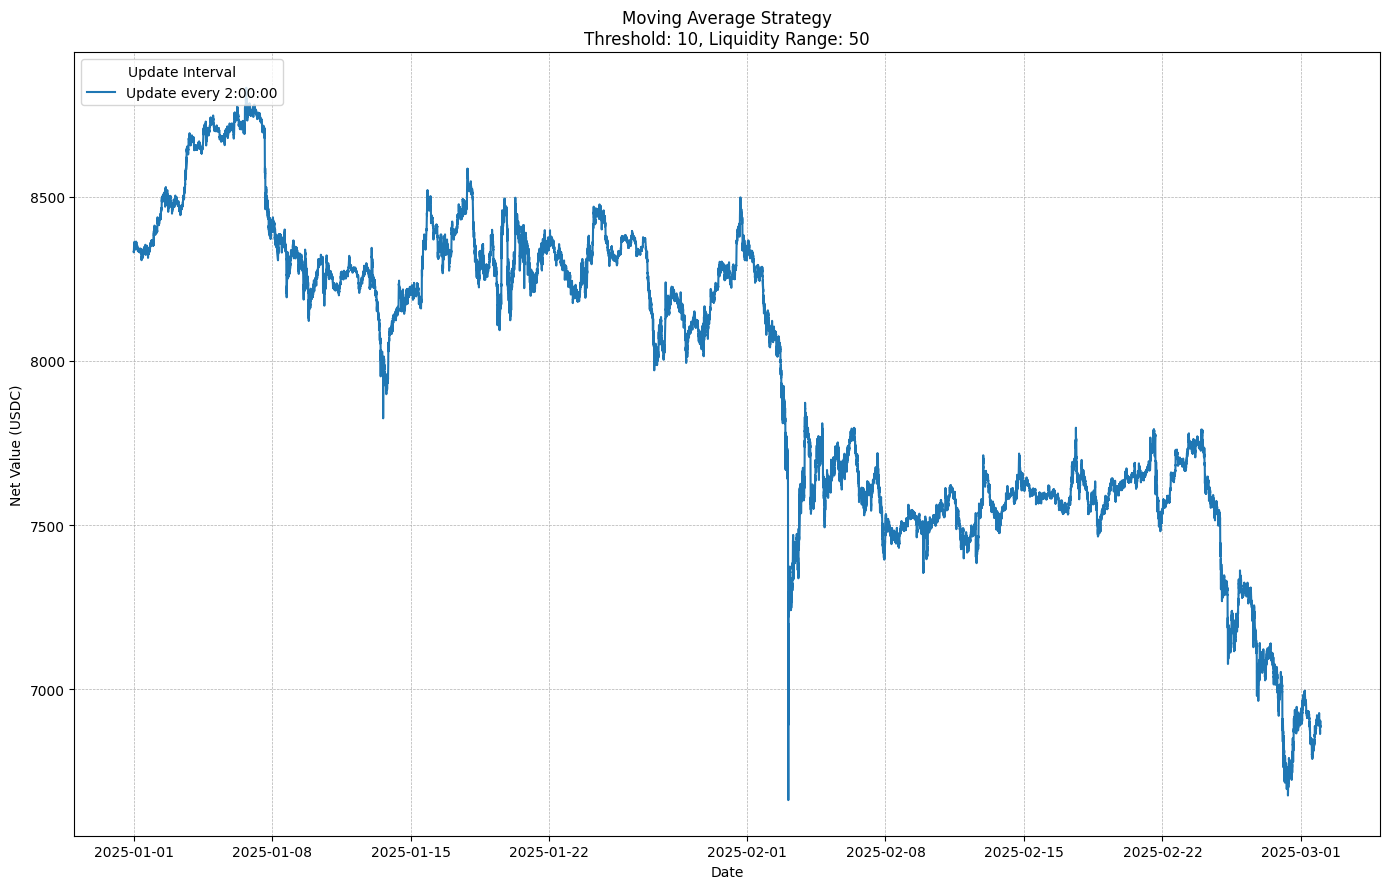

In [ ]:
# Parameter sets
thresholds = [10, 25, 50]
liquidity_ranges = [50, 100, 200]
update_intervals = [timedelta(hours=2), timedelta(hours=6), timedelta(days=1), timedelta(days=7), timedelta(days=14)]

# Loop through parameter combinations and plot results
for threshold in thresholds:
    for liquidity_range in liquidity_ranges:
        plt.figure(figsize=(14, 9))
        for update_interval in update_intervals:
            net_value_series = run_strategy(threshold, liquidity_range, update_interval)
            plt.plot(net_value_series.index, net_value_series, label=f"Update every {update_interval}")

        # Customize and display the plot for each threshold-liquidity range combination
        plt.title(f"Moving Average Strategy\nThreshold: {threshold}, Liquidity Range: {liquidity_range}")
        plt.xlabel("Date")
        plt.ylabel("Net Value (USDC)")
        plt.legend(title="Update Interval", loc="upper left", fontsize=10)
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()